# encoder-GAN learnable latent mapping

### Description of idea

There exists problem of GAN inversion, where we want to learn a map to latent codes of GAN, which ultimately enables us to edit images in latent space and produce transitions from one another.

What we want to try is to utilize latent space of pretrained encoder, which was trained in ss contrastive manner (cause we know that it's latent space is great). We want to learn mapping $m(\cdot)$ from latent space of this encoder to latent space of encoder to latent space of GAN. 

We also propose a new pipeline for this kind of training. Usually there exists a complex pipeline starting from image which is encoded into latent, then mapped, then decoded by GAN into generated image. This pipeline suggest usage of complex 'consistency' losses, which account for reconstruction of image being inverted from latent codes. Instead we suggest to start from latent codes, generate an image and then encode it. This naturally eliminates needs for any consistency loss, as we are operating purely on latents.

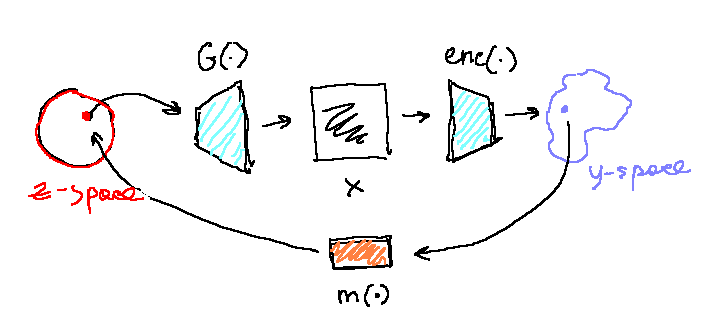

Here, only mapping $m(\cdot)$ is trainable, everything else is pretrained and fixed!

## Simplest experiment with MNIST dataset

For our simplest experiment, we need to obtain two things

- generator $G(\cdot)$ from GAN training on MNIST
- self-supervised trained encoder $enc(\cdot)$, also trained on MNIST

After that, we are ready to learn our mapping $m(\cdot)$.

In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
# !pip install lightly -q

In [3]:
from train_gan import *
from train_encoder import SimCLR

import random

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T
from torchvision.datasets import MNIST, CIFAR10

from utils import *
from IPython.display import clear_output

DEVICE=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SEED=42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED);

class AttributeDict(dict):
    def __getattr__(self, attr):
        return self[attr]
    def __setattr__(self, attr, value):
        self[attr] = value
        
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean=0.5, std=0.5):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())
    
denormalize = NormalizeInverse()
to_pil = T.ToPILImage()


In [4]:
from pathlib import Path
dir_models = Path('models/')
dir_models.mkdir(exist_ok=True)

dir_logs = Path('logs')
dir_logs.mkdir(exist_ok=True)

In [5]:
# !wget https://github.com/csinva/gan-vae-pretrained-pytorch/raw/master/mnist_dcgan/weights/netG_epoch_99.pth  -O models/mnist_gan.pth -q
# !wget https://github.com/csinva/gan-vae-pretrained-pytorch/raw/master/cifar10_dcgan/weights/netG_epoch_199.pth -O models/cifar10_gan.pth -q

In [6]:
z_dim=100
y_dim=512

class M(nn.Module):
    """Learnable projection from y-space to z-space"""
    def __init__(self, n_hidden_layers, hidden_dim, y_dim, z_dim):
        """_summary_

        Args:
            n_hidden_layers (_type_): _description_
            hidden_dim (_type_): _description_
            y_dim (_type_): _description_
            z_dim (_type_): _description_
        """
        super().__init__()
        layers = [nn.Linear(y_dim, hidden_dim)]
        for _ in range(n_hidden_layers):
            layers += [nn.GELU(), nn.Linear(hidden_dim, hidden_dim)]
        layers += [nn.GELU(), nn.Linear(hidden_dim, z_dim)]
        self.projection = nn.Sequential(*layers)

    def forward(self, y):
        return self.projection(y)

In [7]:
G = Generator_CIFAR10(nc=3).to(DEVICE)
G.load_state_dict(torch.load("models/cifar10_gan_500e.pth"))
G.eval()
                  
for p in G.parameters():
    p.requires_grad = False

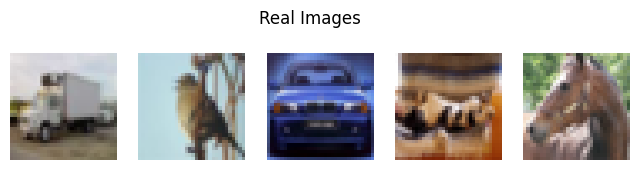

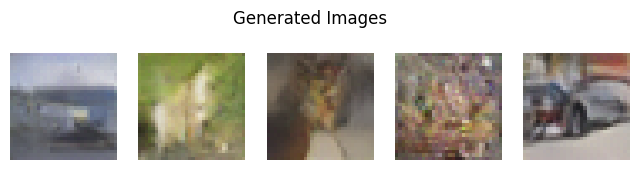

In [8]:
# Real Images holdset
holdout_dataset = CIFAR10(root="data", train=False, download=False, 
    transform=T.Compose([
        T.ToTensor(),
        T.Normalize((0.5,), (0.5,)),
]))

eval_samples = torch.stack([holdout_dataset[idx][0] for idx in random.sample(range(len(holdout_dataset)), k=5)]).to(DEVICE)
images_real_eval = eval_samples

images_real_eval = [to_pil(img_) for img_ in denormalize(images_real_eval)]
_, axs = plt.subplots(1, 5, figsize=(8, 2)) 
for (ax, img) in zip(axs, images_real_eval):
    ax.imshow(img)
    ax.axis('off')
plt.suptitle('Real Images')
plt.show()

# Generated Images holdset
z = torch.randn((5, z_dim), device=DEVICE)
with torch.no_grad():
    images = G(z[:,:, None, None])

images_generated_eval = [to_pil(img_) for img_ in denormalize(images)]
_, axs = plt.subplots(1, 5, figsize=(8, 2))
for (ax, img) in zip(axs, images_generated_eval):
    ax.imshow(img)
    ax.axis('off')
plt.suptitle('Generated Images')
plt.show()

## Trying to fit map with CLIP-image encoder

Training custom encoder on same data domain is fine, but ideally we would like to utilize some big pretrained thing with good embeddings for the suppoert of generation model. Let's try this with CLIP

In [9]:
import clip
model, preprocess = clip.load("ViT-B/32", device=DEVICE)

In [11]:
# pre-trained gan 
G = Generator_CIFAR10(nc=3).to(DEVICE)
G.load_state_dict(torch.load("models/cifar10_gan_500e.pth"))
G.requires_grad_(False)         
G.eval()

Generator_CIFAR10(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [13]:
# eval_samples = [holdout_data[idx][0] for idx in random.sample(range(len(holdout_data)), k=5)]

n_px=model.visual.input_resolution

clip_transform = T.Compose([
    T.Resize(n_px, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
    T.CenterCrop(n_px),
    T.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])

eval_transform = T.Compose([
    T.Resize(n_px, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
    T.CenterCrop(n_px),
    T.ToTensor(),
    T.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])

Adding masking 

In [14]:
from IPython.display import clear_output
    
def train_latent_map_clip(
        mapping: nn.Module, 
        generator: nn.Module, 
        encoder: nn.Module, 
        loss_fn, # loss function used on latents
        optimizer, 
        num_iters=5000, 
        eval_iters=1000, # ? 
        batch_size=512, 
        ema=None,
        image_augmentations=None,
        args=AttributeDict(),
        plot_every=None,
        eval_samples=images_generated_eval,
    ):
    generator.eval()
    encoder.eval()
    mapping.train()

    loss_hist = []
    p_bar = tqdm(range(num_iters))
    for i in p_bar:
        optimizer.zero_grad()
        z = torch.randn((batch_size, z_dim), device=DEVICE)
        with torch.no_grad():
            images = denormalize(generator(z[:,:, None, None]))
            # Saving images for later reconstruction loss
            if args.loss_reconstruction is not None:
                images_original = images.clone()
            if image_augmentations is not None:
                images = image_augmentations(images)
            images = clip_transform(images)
            y = encoder.encode_image(images).squeeze(0).float()
            if args.noise_lantents:
                y += args.nl_scale*torch.randn_like(y)
                
        if args.adv_loss_used:
            loss = loss_fn(mapping, y, z)
        else:
            z_hat = mapping(y)
            loss = loss_fn(z_hat, z)
            
        if args.loss_reconstruction is not None:
            imgs_hat = denormalize(G(z_hat[:, :, None, None]))
            loss += args.rec_loss_scale * args.loss_reconstruction(imgs_hat, images_original)
        
        loss.backward()
        optimizer.step()
        if ema is not None:
            ema.update()
        
        loss_hist.append(loss.item())
        p_bar.set_postfix(loss=loss.item())
        
        if plot_every is not None:
            if i % plot_every == 0:
                clear_output(wait=True)
                visualize_inversion_clip(eval_samples, mapping, encoder=model,)
        
    return loss_hist, mapping

@torch.no_grad()
def visualize_inversion_clip(eval_samples, mapping, encoder, saved_weights_path=None):
    if saved_weights_path is not None:
        mapping.load_state_dict(torch.load(saved_weights_path))
        
    mapping.eval()
    images=torch.stack([eval_transform(img) for img in eval_samples]).to(DEVICE)
    y = encoder.encode_image(images).squeeze(0).float()
    z_hat = mapping(y)[:,:, None, None]
    inv_samples = denormalize(G(z_hat)).permute(0,2,3,1)

    _, axs = plt.subplots(2, 5, figsize=(16, 6))
    for i in range(5):
        img_orig = np.array(eval_samples[i])
        img_invers = inv_samples[i].cpu().numpy()
        axs[0][i].imshow(img_orig)
        axs[1][i].imshow(img_invers)
    for ax in np.ravel(axs):
        ax.set_axis_off()
    plt.show()

In [18]:
num_iters = 3000

Training `m()` without inpainting augmentation


  0%|          | 0/3000 [00:00<?, ?it/s]

c:\Users\MQTyor\ai_pc\ENVS_general\cmpttv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 3000/3000 [10:03<00:00,  4.97it/s, loss=0.898]


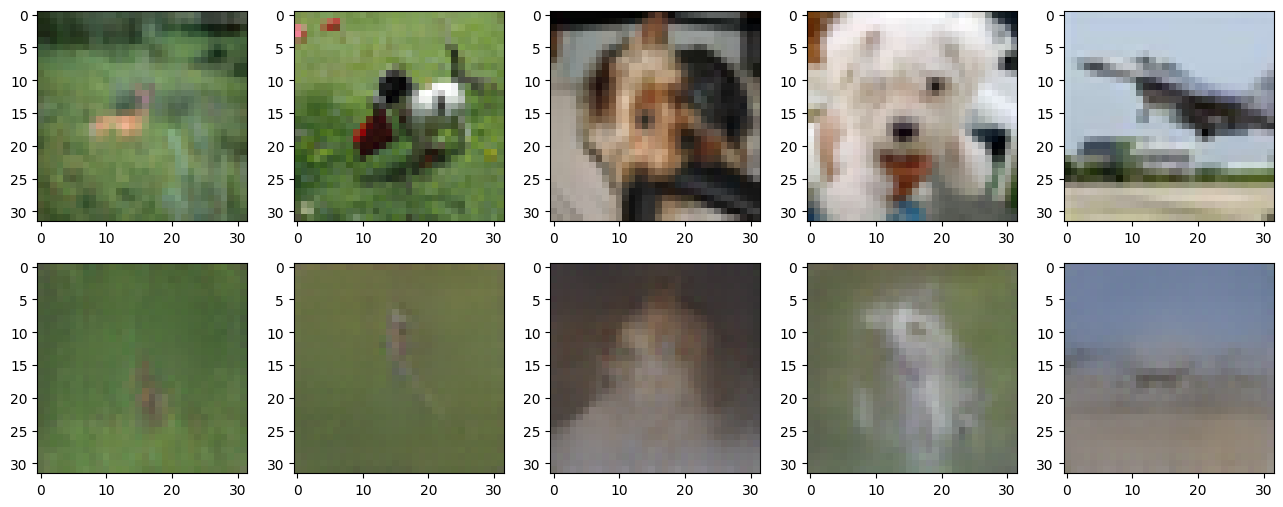

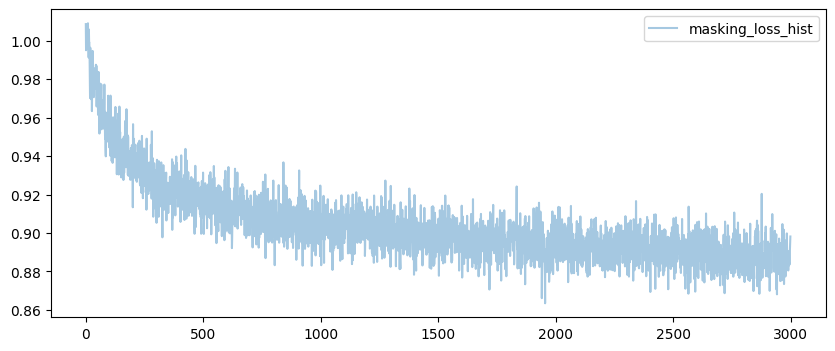

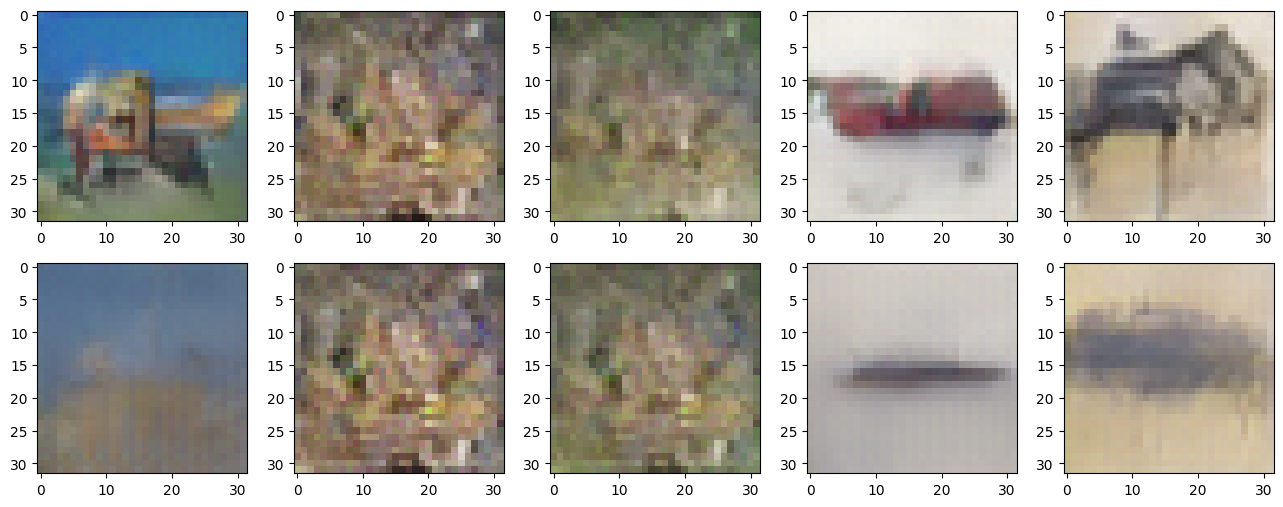

In [29]:
args = AttributeDict()
args.noise_lantents = False
args.adv_loss_used = False
args.rec_loss_scale = 0. # loss(x, G(z))
args.loss_reconstruction = None

z_dim=100
y_dim=512
n_hidden=4
hidden_dim=256
mapping = M(n_hidden, hidden_dim, y_dim, z_dim).to(DEVICE)
optimizer = optim.Adam(mapping.parameters(), lr=3e-3)

batch_size = 256

masking_loss_hist, mapping = train_latent_map_clip(
    mapping=mapping, 
    generator=G, 
    encoder=model, 
    loss_fn=F.mse_loss,
    optimizer=optimizer, 
    num_iters=num_iters, 
    batch_size=batch_size,
    # image_augmentations=T.RandomErasing(),
    args=args,
    plot_every=None,
    # eval_samples=images_real_eval,
)

torch.save(mapping.state_dict(), f"models/mapping_cifar_clip_b_{n_hidden}_{hidden_dim}.pth")

visualize_inversion_clip(
    images_real_eval, 
    mapping, 
    encoder=model, 
    # saved_weights_path="models\mapping_clip_b_4_256_inpaint.pth"
)

plot_losses({"masking_loss_hist": masking_loss_hist})
visualize_inversion_clip(
    images_generated_eval, 
    mapping, 
    encoder=model, 
    # saved_weights_path="models\mapping_clip_b_4_256_inpaint.pth"
)



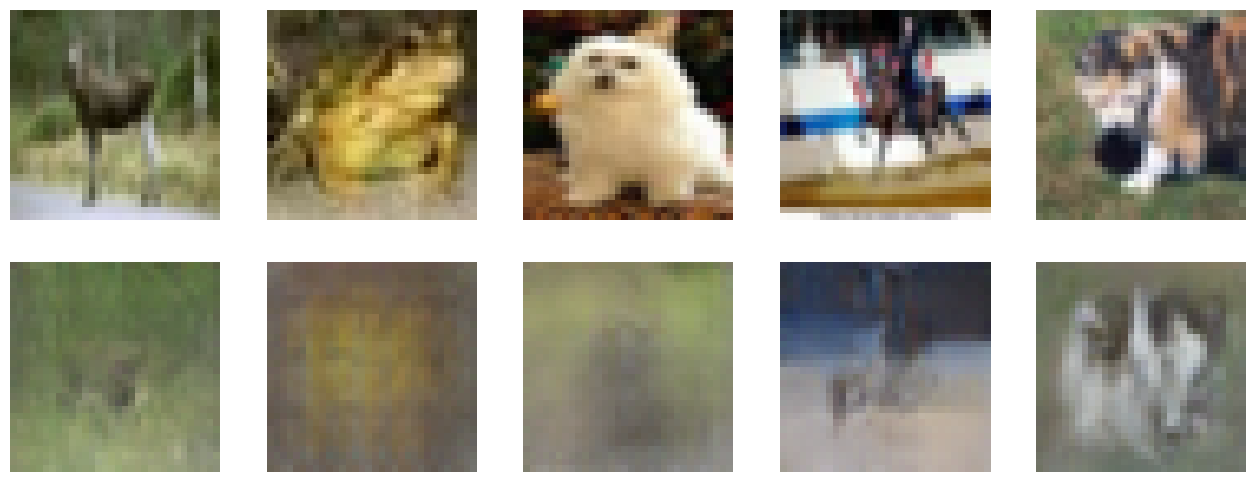

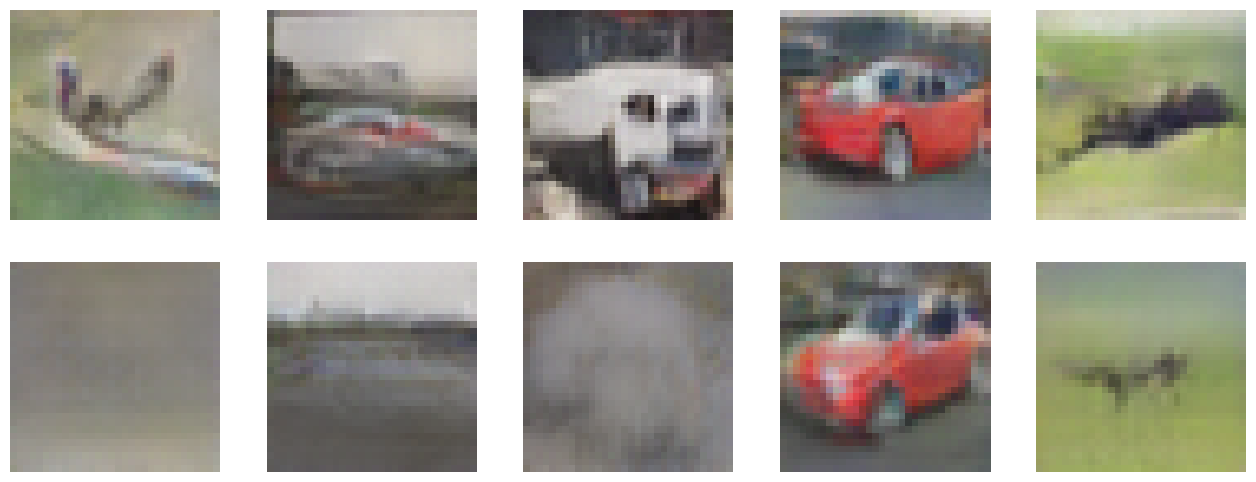

In [63]:
visualize_inversion_clip(
    images_real_eval, 
    mapping, 
    encoder=model, 
    # saved_weights_path="models\mapping_clip_b_4_256_inpaint.pth"
)

visualize_inversion_clip(
    images_generated_eval, 
    mapping, 
    encoder=model, 
    # saved_weights_path="models\mapping_clip_b_4_256_inpaint.pth"
)

Training `m()` with inpainting augmentation

  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [09:42<00:00,  5.15it/s, loss=0.891]


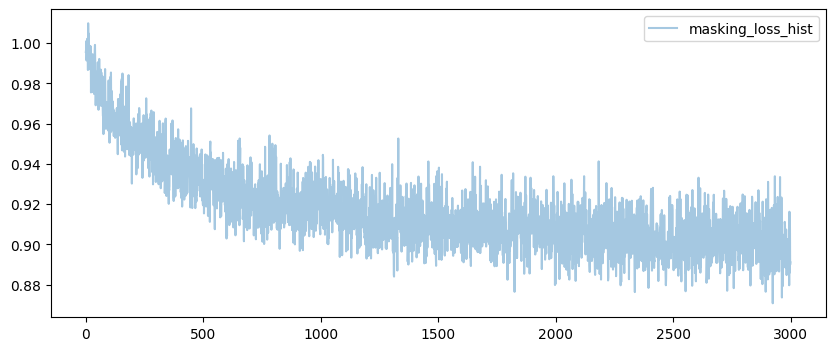

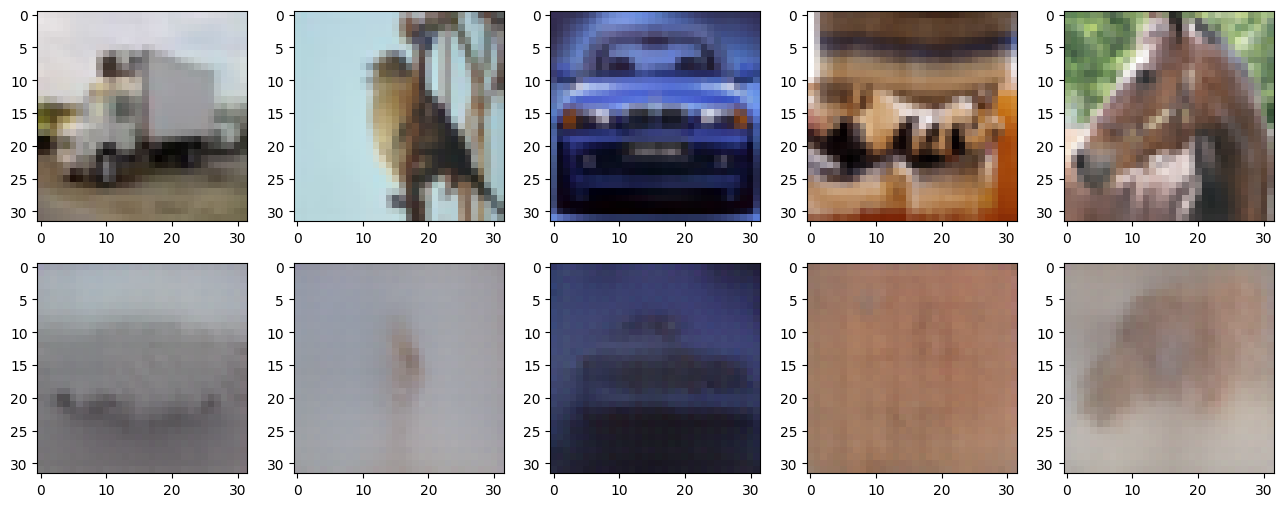

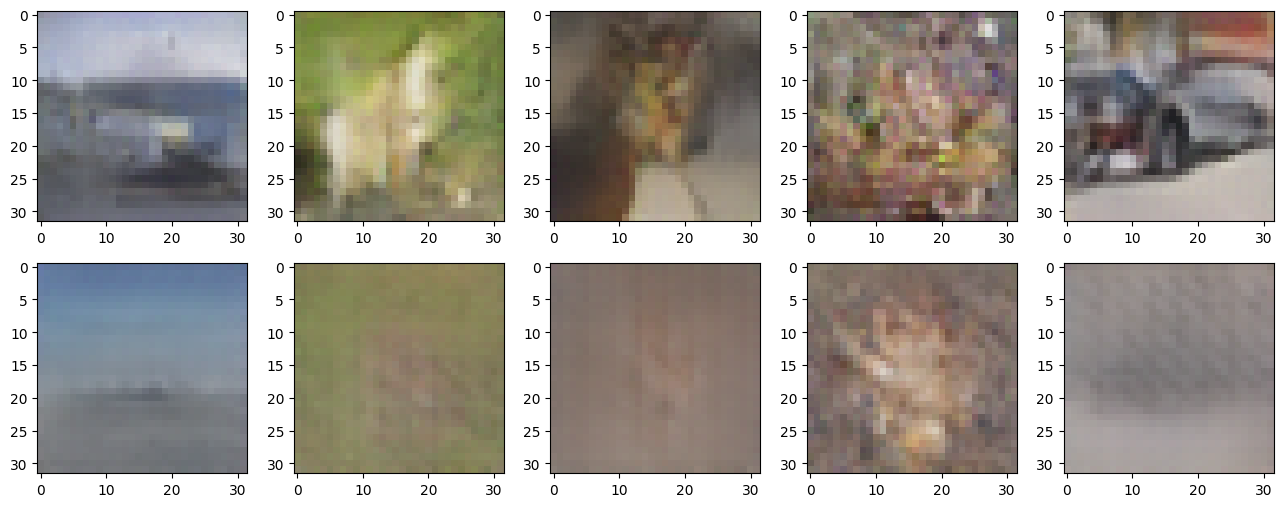

In [17]:
args = AttributeDict()
args.noise_lantents = False
args.adv_loss_used = False
args.rec_loss_scale = 0. # loss(x, G(z))
args.loss_reconstruction = None

mapping = M(n_hidden, hidden_dim, y_dim, z_dim).to(DEVICE)
optimizer = optim.Adam(mapping.parameters(), lr=3e-3)
batch_size = 256

masking_loss_hist, mapping = train_latent_map_clip(
    mapping=mapping, 
    generator=G, 
    encoder=model, 
    loss_fn=F.mse_loss,
    optimizer=optimizer, 
    num_iters=num_iters, 
    batch_size=batch_size,
    image_augmentations=T.RandomErasing(),
    args=args,
    plot_every=None
)

torch.save(mapping.state_dict(), f"models/mapping_cifar_clip_b_{n_hidden}_{hidden_dim}_inpaint.pth")
plot_losses({"masking_loss_hist": masking_loss_hist})

visualize_inversion_clip(
    images_real_eval, 
    mapping, 
    encoder=model, 
    # saved_weights_path="models\mapping_clip_b_4_256_inpaint.pth"
)

visualize_inversion_clip(
    images_generated_eval, 
    mapping, 
    encoder=model, 
    # saved_weights_path="models\mapping_clip_b_4_256_inpaint.pth"
)


Since the inpainting augmentation does not help improve generations, let's try reconstruction loss compound that is the main part of GAN inversion.

  0%|          | 0/3000 [00:00<?, ?it/s]c:\Users\MQTyor\ai_pc\ENVS_general\cmpttv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 3000/3000 [11:00<00:00,  4.54it/s, loss=1.04]


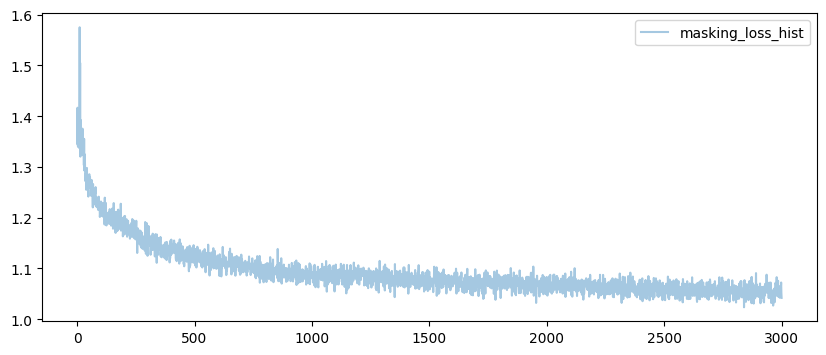

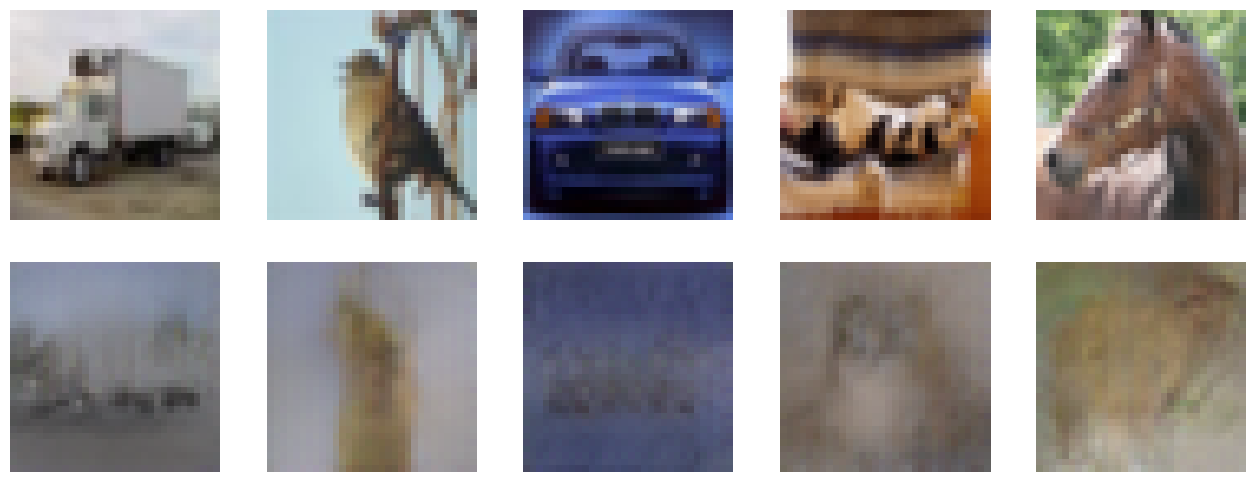

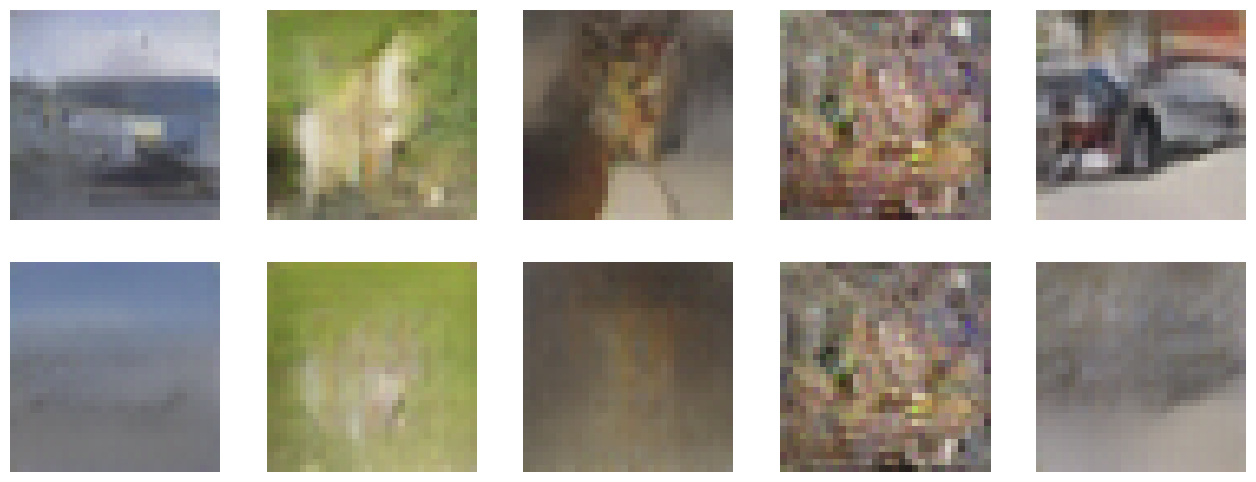

In [20]:
args = AttributeDict()
args.noise_lantents = False
args.adv_loss_used = False
args.rec_loss_scale = 10 # loss(x, G(z))
args.loss_reconstruction = F.mse_loss

n_hidden = 4
hidden_dim = 512
mapping = M(n_hidden, hidden_dim, y_dim, z_dim).to(DEVICE)
optimizer = optim.Adam(mapping.parameters(), lr=3e-3)
batch_size = 256

masking_loss_hist, mapping = train_latent_map_clip(
    mapping=mapping, 
    generator=G, 
    encoder=model, 
    loss_fn=F.mse_loss,
    optimizer=optimizer, 
    num_iters=num_iters, 
    batch_size=batch_size,
    # image_augmentations=T.RandomErasing(),
    args=args,
    plot_every=None
)

torch.save(mapping.state_dict(), f"models/mapping_cifar_clip_b_{n_hidden}_{hidden_dim}_recscale{args.rec_loss_scale}.pth")
plot_losses({"masking_loss_hist": masking_loss_hist})

visualize_inversion_clip(
    images_real_eval, 
    mapping, 
    encoder=model, 
    # saved_weights_path="models\mapping_clip_b_4_256_inpaint.pth"
)

visualize_inversion_clip(
    images_generated_eval, 
    mapping, 
    encoder=model, 
    # saved_weights_path="models\mapping_clip_b_4_256_inpaint.pth"
)


In [ ]:
args = AttributeDict()
args.noise_lantents = False
args.adv_loss_used = False
args.rec_loss_scale = 10 # loss(x, G(z))
args.loss_reconstruction = F.mse_loss

n_hidden = 4
hidden_dim = 512
mapping = M(n_hidden, hidden_dim, y_dim, z_dim).to(DEVICE)
optimizer = optim.Adam(mapping.parameters(), lr=3e-3)
batch_size = 256

masking_loss_hist, mapping = train_latent_map_clip(
    mapping=mapping, 
    generator=G, 
    encoder=model, 
    loss_fn=F.mse_loss,
    optimizer=optimizer, 
    num_iters=num_iters, 
    batch_size=batch_size,
    # image_augmentations=T.RandomErasing(),
    args=args,
    plot_every=None
)

torch.save(mapping.state_dict(), f"models/mapping_cifar_clip_b_{n_hidden}_{hidden_dim}_recscale{args.rec_loss_scale}.pth")
plot_losses({"masking_loss_hist": masking_loss_hist})

visualize_inversion_clip(
    images_real_eval, 
    mapping, 
    encoder=model, 
    # saved_weights_path="models\mapping_clip_b_4_256_inpaint.pth"
)

visualize_inversion_clip(
    images_generated_eval, 
    mapping, 
    encoder=model, 
    # saved_weights_path="models\mapping_clip_b_4_256_inpaint.pth"
)

# Measuring image quality 

In [1]:
# %pip install piq

In [40]:
import clip

n_hidden = 4
hidden_dim = 256
mapping = M(n_hidden, hidden_dim, y_dim, z_dim).to(DEVICE)
mapping.load_state_dict(torch.load("models/mapping_cifar_clip_b_4_256.pth"))
encoder, preprocess = clip.load("ViT-B/32", device=DEVICE)
G = Generator_CIFAR10(nc=3).to(DEVICE)
G.load_state_dict(torch.load("models/cifar10_gan_500e.pth"))
# G.load_state_dict(torch.load("models/cifar10_gan.pth"))
G.requires_grad_(False)
encoder.requires_grad_(False)
mapping.requires_grad_(False)
G.eval()
encoder.eval()

cifar_test = CIFAR10(root="data", train=False, download=False, 
    transform=T.Compose([
        T.ToTensor(),
        # T.Normalize((0.5,), (0.5,)),
]))
images_real_orig = torch.stack([img[0].to('cuda') for img in cifar_test])

@torch.no_grad()
def inverse_imgs(dataset_to_reconstruct, mapping, generator, transform, chunk_size=128):
    """_summary_

    Args:
        dataset_to_reconstruct (_type_): _description_
        mapping (_type_): _description_
        generator (_type_): _description_
        transform (_type_): _description_
        chunk_size (int, optional): _description_. Defaults to 128.

    Returns:
        dataset_to_reconstruct: torch.tensor _description_
    """
    images_generated_rec = []
    for i in range(0, len(dataset_to_reconstruct), chunk_size):
        chunk = transform(dataset_to_reconstruct[i:i+chunk_size])
        y = encoder.encode_image(chunk).squeeze(0).float()
        z_hat = mapping(y)
        images_generated_rec.append(denormalize(generator(z_hat[:, :, None, None])))
        
    return torch.cat(images_generated_rec).to('cpu')

z = torch.randn((10_000, z_dim), device=DEVICE)
with torch.no_grad():
    # Generating original images
    images_gen_orig = denormalize(G(z[:,:, None, None]))
    # Reconstructing generated images
    images_gen_rec = inverse_imgs(
        dataset_to_reconstruct=images_gen_orig,
        mapping=mapping,
        generator=G,
        transform=clip_transform,
        chunk_size=128
    )
    # Generating reconstructed images from inversion
    images_real_rec = inverse_imgs(
        dataset_to_reconstruct=images_real_orig,
        mapping=mapping,
        generator=G,
        transform=clip_transform,
        chunk_size=128
    )
    
images_gen_orig = images_gen_orig.to('cpu')
# images_gen_rec
images_real_orig = images_real_orig.to("cpu")
# images_real_rec


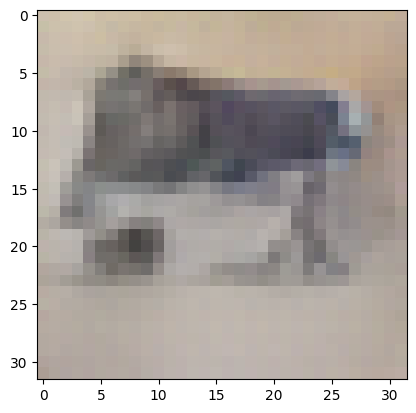

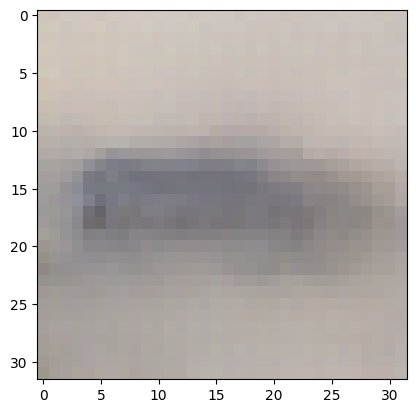

In [36]:
id = 7295
plt.imshow(images_gen_orig[id].permute(1,2,0))
plt.show()
plt.imshow(images_gen_rec[id].permute(1,2,0))
plt.show()

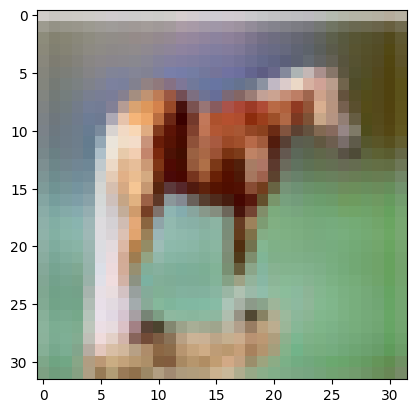

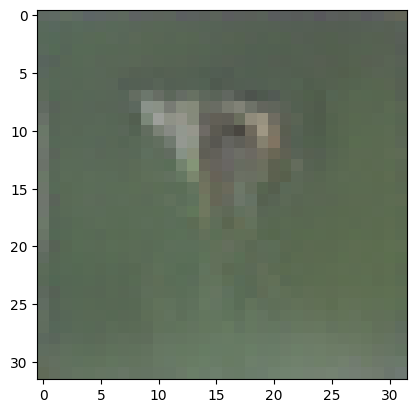

In [38]:
id = 795
plt.imshow(images_real_orig[id].permute(1,2,0))
plt.show()
plt.imshow(images_real_rec[id].permute(1,2,0))
plt.show()

In [41]:
print(torch.min(images_gen_orig), torch.max(images_gen_orig))
print(torch.min(images_gen_rec), torch.max(images_gen_rec))
print(torch.min(images_real_orig), torch.max(images_real_orig))
print(torch.min(images_real_rec), torch.max(images_real_rec))

tensor(0.0094) tensor(0.9971)
tensor(0.0104) tensor(0.9777)
tensor(0.) tensor(1.)
tensor(0.0378) tensor(0.9663)


In [19]:
from torch.utils.data import DataLoader, Dataset
from piq import FID, IS, LPIPS

class piq_dataset(Dataset):
    def __init__(self, images: torch.tensor):
        self.images = images
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        x = self.images[index]
        return {'images': x}

dd_metrics = {'real':{}, 'generated':{}}
fid_metric = FID()
lpips_metric = LPIPS()
is_metric = IS()

for label, imgs_orig, imgs_rec in zip(('real', 'generated'), (images_real_orig, images_gen_orig), (images_real_rec, images_gen_rec)):
    orig_dl = DataLoader(piq_dataset(imgs_orig), batch_size=128)
    rec_dl = DataLoader(piq_dataset(imgs_rec), batch_size=128)
    # # FID
    x_feats = fid_metric.compute_feats(orig_dl)
    y_feats = fid_metric.compute_feats(rec_dl)
    fid_distance = fid_metric(x_feats, y_feats)
    # IS
    x_feats = is_metric.compute_feats(orig_dl)
    y_feats = is_metric.compute_feats(rec_dl)
    is_score = is_metric(x_feats, y_feats)
    # # LPIPS
    lpips_distance = lpips_metric(imgs_orig, imgs_rec)
    dd_metrics[label]['fid'] = fid_distance
    dd_metrics[label]['is'] = is_score
    dd_metrics[label]['lpips'] = lpips_distance

c:\Users\MQTyor\ai_pc\ENVS_general\cmpttv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MQTyor\ai_pc\ENVS_general\cmpttv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NameError: name 'images_real_orig' is not defined

In [52]:
dd_metrics

{'real': {'fid': tensor(121.5640, dtype=torch.float64),
  'is': tensor(0.0140),
  'lpips': tensor(0.5846)},
 'generated': {'fid': tensor(106.6844, dtype=torch.float64),
  'is': tensor(0.0060),
  'lpips': tensor(0.4547)}}